/samoa/data/smrserraoseabr/.conda_samoa/envs/NN/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/samoa/data/smrserraoseabr/.conda_samoa/envs/NN/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/samoa/data/smrserraoseabr/.conda_samoa/envs/NN/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/samoa/data/smrserraoseabr/.conda_samoa/envs/NN/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


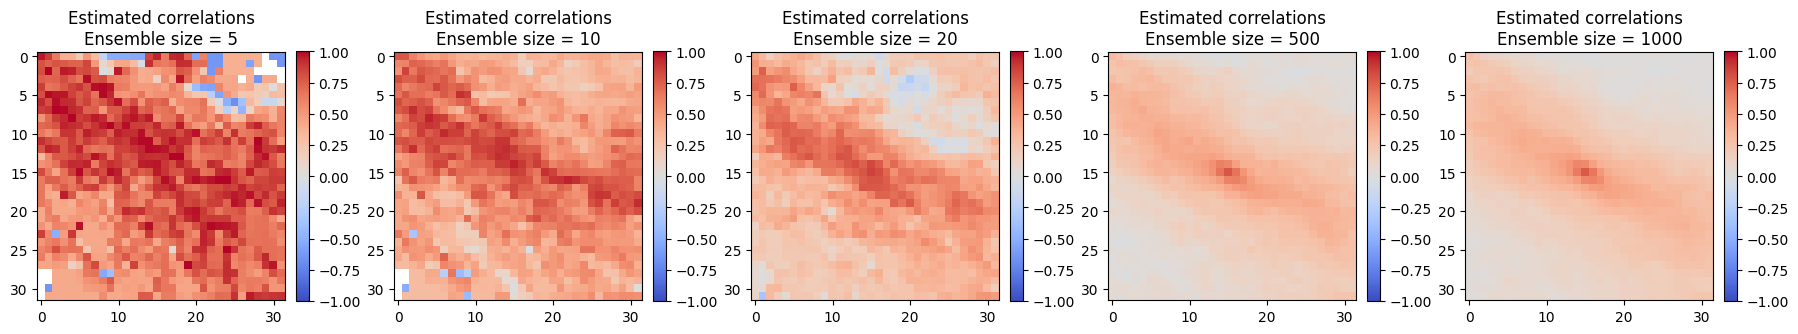

In [47]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Define the specific grid point for pressure
pressure_point = (15, 15)  # for example, pick the middle point

# Define the ensemble sizes
#create a list of ensemble sizes with 10 different values
ensemble_sizes = [5, 10, 20, 500, 1000]
grid_size = 32
# Define the file pattern for the ensemble realizations
file_pattern = '/samoa/data/smrserraoseabr/NO-DA/dataset/mixedcontext32x32/simulation_results_realization_32x32_{}.nc'

# Initialize the ensemble correlation for each ensemble size
ensemble_correlations = []

for ensemble_size in ensemble_sizes:
    # Initialize the ensemble of pressure and permeability
    pressure_ensemble = []
    perm_ensemble = []

    for i in range(1, ensemble_size + 1):
        # Load the dataset
        data = xr.open_dataset(file_pattern.format(i))

        # Get the pressure at the specific grid point and the last time step
        pressure = data['Pressure'].isel(time=-1, Y=pressure_point[0], X=pressure_point[1]).values
       # Get the permeability
        perm = data['Perm'].values.flatten()

        pressure_ensemble.append(pressure)
        perm_ensemble.append(perm)

    # Convert to numpy arrays
    pressure_ensemble = np.array(pressure_ensemble)
    perm_ensemble = np.array(perm_ensemble)

    # Compute the correlation for each grid point
    correlations = [np.corrcoef(pressure_ensemble, perm_ensemble[:, j])[0, 1] for j in range(grid_size ** 2)]

    ensemble_correlations.append(correlations)

# Reshape the correlations to 2D grids for visualization
correlation_grids = [np.array(corr).reshape((grid_size, grid_size)) for corr in ensemble_correlations]

# Create plots
fig, axs = plt.subplots(1, len(ensemble_sizes), figsize=(18, 4))

# Plot the estimated correlations for each ensemble size
for i, ensemble_size in enumerate(ensemble_sizes):
    cax = axs[i].imshow(correlation_grids[i], vmin=-1, vmax=1, cmap='coolwarm')
    axs[i].set_title(f'Estimated correlations\nEnsemble size = {ensemble_size}')
    fig.colorbar(cax, ax=axs[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


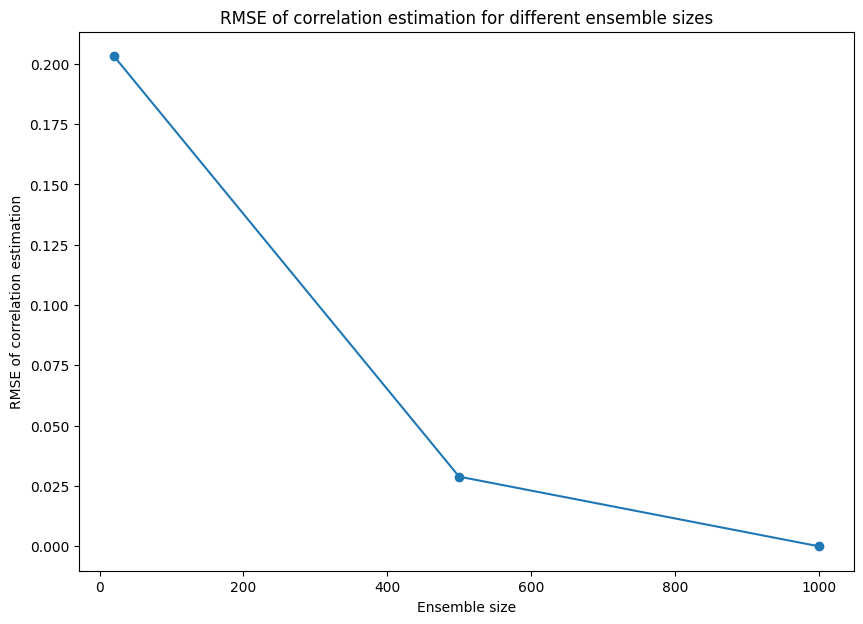

In [48]:
# Compute the "true" correlation as the correlation estimated with the largest ensemble size
true_correlation = np.array(ensemble_correlations[-1])

# Initialize the RMSE for each ensemble size
rmse = []

for correlations in ensemble_correlations:
    # Convert the list to a NumPy array
    correlations = np.array(correlations)
    
    # Compute the RMSE
    error = np.sqrt(np.mean((correlations - true_correlation) ** 2))
    rmse.append(error)

# Create plot
plt.figure(figsize=(10, 7))
plt.plot(ensemble_sizes, rmse, marker='o')
plt.xlabel('Ensemble size')
plt.ylabel('RMSE of correlation estimation')
plt.title('RMSE of correlation estimation for different ensemble sizes')
plt.show()


In [42]:
# %%
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patches as mpatches
import pandas as pd
import re
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from utilities import *
import imageio
from io import BytesIO
from IPython.display import Image as DisplayImage
from model_fourier_3d import *
import torchmetrics
print(torch.__version__)
print(f"GPUs:{torch.cuda.device_count()}")
import os
print(os.getcwd())

# %%
###############################################
#INTIAL CONFIGS
# DATASET
DATA_FOLDER = '/samoa/data/smrserraoseabr/NO-DA/dataset/mixedcontext32x32' #'../dataset/DARTS/runnedmodels_wells/filtered' #"../dataset/DARTS/runnedmodels_wells/filtered"  #"/nethome/atena_projetos/bgy3/NO-DA/datasets/results" + str(resolution) + "/"
INPUT_VARS = ['Por', 'Perm', 'gas_rate'] # Porosity, Permeability, ,  Well 'gas_rate', Pressure + x, y, time encodings 
OUTPUT_VARS = ['Pressure'] 
#CONFIGS OF THE MODEL TO GENERATE RESULTS
path_runs = \
    '/samoa/data/smrserraoseabr/NO-DA/runs/FNO_3d_N800.0_ep110_m18_w128_b10_INPUT_Por_Perm_gas_rate_OUTPUT_Pressure'
path_model= \
    '/samoa/data/smrserraoseabr/NO-DA/runs/FNO_3d_N800.0_ep110_m18_w128_b10_INPUT_Por_Perm_gas_rate_OUTPUT_Pressure/FNO_3d_N800.0_ep110_m18_w128_b10_INPUT_Por_Perm_gas_rate_OUTPUT_Pressure_model.pt'

NUM_FILES= 1000
BATCH_SIZE = 1
TRAINTEST_SPLIT = 0.8
WELLS_POSITIONS = False
#DEVICE SETTINGS
device = 'cuda' if torch.cuda.is_available() else 'cpu'

###############################################
variable = OUTPUT_VARS[0]
ntrain = NUM_FILES * TRAINTEST_SPLIT
ntest = NUM_FILES - ntrain


#CHCEK IF FOLDERS EXISTS
if not os.path.exists(path_runs):
    raise ValueError(f'Path {path_runs} does not exist.')
if not os.path.exists(path_model):
       raise ValueError(f'Path {path_model} does not exist.')


# Create instance of ReadXarrayDatasetNorm class for training data
dataset = ReadXarrayDataset(folder=DATA_FOLDER, input_vars=INPUT_VARS, output_vars=OUTPUT_VARS, num_files = NUM_FILES, wells_positions=WELLS_POSITIONS)

train_size = int(TRAINTEST_SPLIT * len(dataset))
test_size = len(dataset) - train_size


train_loader = DataLoader(torch.utils.data.Subset(dataset, range(0, train_size)),
                           batch_size=BATCH_SIZE,
                             shuffle=False)
test_loader = DataLoader(torch.utils.data.Subset(dataset, range(train_size, train_size + test_size)), 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)
#LOAD NORMALIZATION PARAMETERS

# Normalize input_data and output_data
#check if normalizer exists and load it, otherwise raise a warning and create a new one
if os.path.exists(os.path.join(path_runs,'normalizer_mean_input.pt')):
    input_normalizer_mean = torch.load(os.path.join(path_runs,'normalizer_mean_input.pt'))
    input_normalizer_std = torch.load(os.path.join(path_runs,'normalizer_std_input.pt'))
    output_normalizer_mean = torch.load(os.path.join(path_runs,'normalizer_mean_output.pt'))
    output_normalizer_std = torch.load(os.path.join(path_runs,'normalizer_std_output.pt'))
    print('Normalizer loaded')
    input_normalizer = PointGaussianNormalizer(train_loader, mean = input_normalizer_mean, std = input_normalizer_std, is_label=False)
    output_normalizer = PointGaussianNormalizer(train_loader, mean = output_normalizer_mean, std = output_normalizer_std, is_label=True)
    input_normalizer = input_normalizer.cuda(device)
    output_normalizer = output_normalizer.cuda(device)

else:
    print('Normalizer not found')
    #raise 
    ValueError(f'Normalizer not found in {path_runs}')

#%%
model = torch.load(path_model, map_location=device).to(device)  # load the model to CPU
model.eval()  # set the model to evaluation mode
print(device)

            

1.13.0+cu117
GPUs:2
/samoa/data/smrserraoseabr/NO-DA/postprocess
Normalizer loaded
cuda


Computing correlations for ensemble size 5


/samoa/data/smrserraoseabr/.conda_samoa/envs/NN/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/samoa/data/smrserraoseabr/.conda_samoa/envs/NN/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Finished computing correlations for ensemble size 5
Computing correlations for ensemble size 10


/samoa/data/smrserraoseabr/.conda_samoa/envs/NN/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/samoa/data/smrserraoseabr/.conda_samoa/envs/NN/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Finished computing correlations for ensemble size 10
Computing correlations for ensemble size 20
Finished computing correlations for ensemble size 20
Computing correlations for ensemble size 500
Finished computing correlations for ensemble size 500
Computing correlations for ensemble size 1000
Finished computing correlations for ensemble size 1000


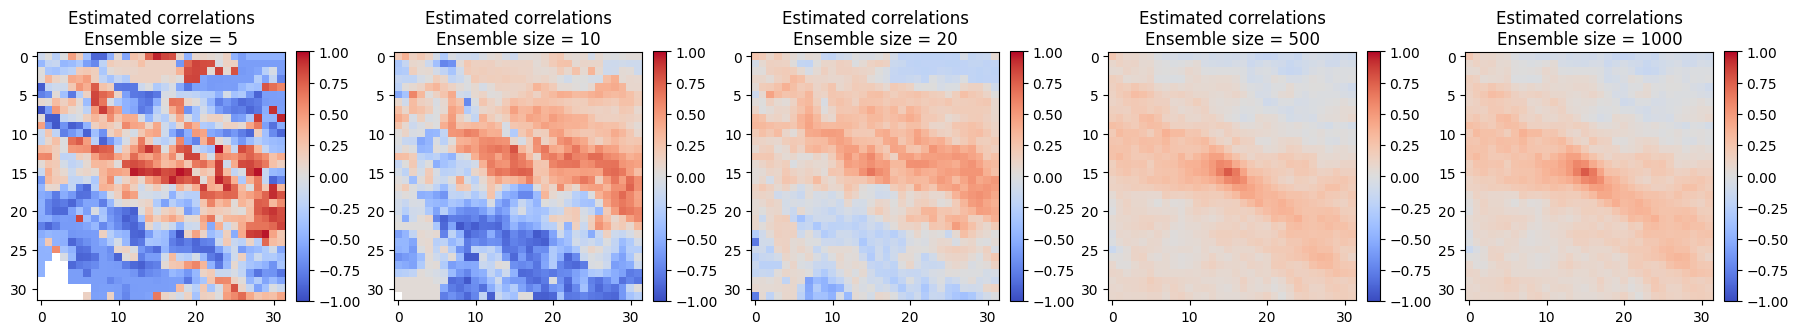

In [43]:
ensemble_sizes = [5, 10, 20, 500, 1000]
# Compute the correlation for a given ensemble size
def compute_correlation_map(ensemble_size, loader, model, input_normalizer, output_normalizer):
    # Initialize the ensemble of pressure and permeability
    pressure_ensemble = []
    perm_ensemble = []

    for i, (x, y) in enumerate(loader):
        if i >= ensemble_size:
            break

        # Get the permeability
        perm = x[:, 0, :, :, 1].detach().cpu().numpy().flatten()  # Adjust this if the permeability is not at index 1

        # Move to device and normalize
        x = x.to(device)
        x = input_normalizer.encode(x)

        # Get the pressure prediction from the model
        out = model(x)
        pressure = output_normalizer.decode(out).detach().cpu().numpy()
        

        # Get the pressure at the specific grid point and the last time step
        pressure = pressure[:, -1, pressure_point[0], pressure_point[1], 0]
        pressure = pressure.item()

        pressure_ensemble.append(pressure)  # Append the scalar pressure value
        perm_ensemble.append(perm)

    # Convert to numpy arrays
    pressure_ensemble = np.array(pressure_ensemble)
    perm_ensemble = np.array(perm_ensemble)

    # Compute the correlation for each grid point
    correlations = [np.corrcoef(pressure_ensemble, perm_ensemble[:, j])[0, 1] for j in range(grid_size ** 2)]

    return correlations


# Compute the correlation for each ensemble size
ensemble_correlations = []
for ensemble_size in ensemble_sizes:
    print(f'Computing correlations for ensemble size {ensemble_size}')
    correlations = compute_correlation_map(ensemble_size, test_loader, model, input_normalizer, output_normalizer)
    ensemble_correlations.append(correlations)
    print(f'Finished computing correlations for ensemble size {ensemble_size}')

# Reshape the correlations to 2D grids for visualization
correlation_grids = [np.array(corr).reshape((grid_size, grid_size)) for corr in ensemble_correlations]

# Create plots
if len(ensemble_sizes) == 1:
    fig, axs = plt.subplots()
    axs = [axs]  # Make it a list even if there's just one
else:
    fig, axs = plt.subplots(1, len(ensemble_sizes), figsize=(18, 4))

# Plot the estimated correlations for each ensemble size
for i, ensemble_size in enumerate(ensemble_sizes):
    cax = axs[i].imshow(correlation_grids[i], vmin=-1, vmax=1, cmap='coolwarm')
    axs[i].set_title(f'Estimated correlations\nEnsemble size = {ensemble_size}')
    fig.colorbar(cax, ax=axs[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()




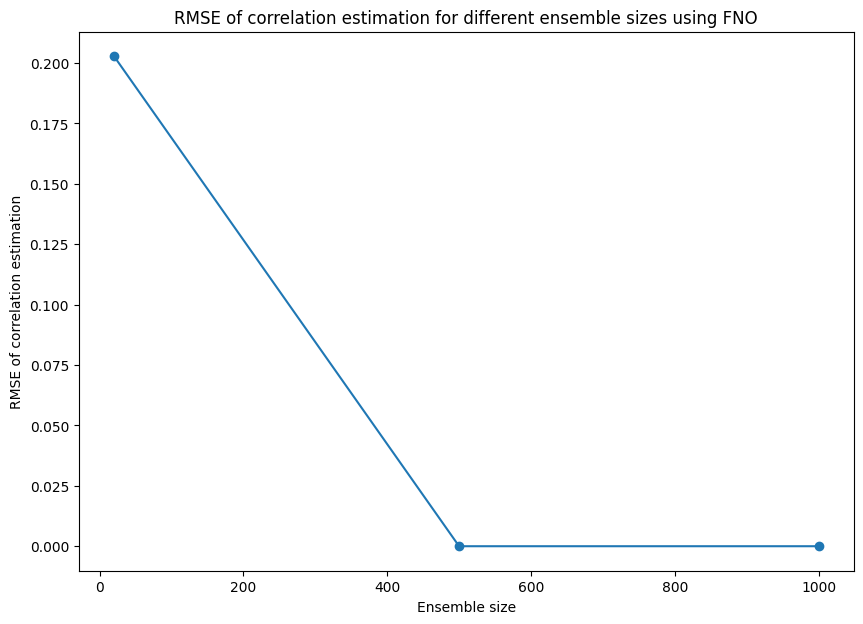

In [44]:
# Compute the "true" correlation as the correlation estimated with the largest ensemble size
true_correlation = np.array(ensemble_correlations[-1])

# Initialize the RMSE for each ensemble size
rmse = []

for correlations in ensemble_correlations:
    # Convert the list to a NumPy array
    correlations = np.array(correlations)
    
    # Compute the RMSE
    error = np.sqrt(np.mean((correlations - true_correlation) ** 2))
    rmse.append(error)

# Create plot
plt.figure(figsize=(10, 7))
plt.plot(ensemble_sizes, rmse, marker='o')
plt.xlabel('Ensemble size')
plt.ylabel('RMSE of correlation estimation')
plt.title('RMSE of correlation estimation for different ensemble sizes using FNO')
plt.show()


In [ ]:

for batch_idx, (x, y) in enumerate(test_loader):        

            #x is the input data, (batch_size, 61,32,32,6), where dim 1 is permeability 
            x = x.to(device)
            true_y = y.to(device)
            x = input_normalizer.encode(x)
            out = model(x)
            out = output_normalizer.decode(out).detach().cpu() #pressure (batch_size, 61,32,32,1) the last dimension is the Pressure 
